In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
#import matplotlib.pyplot as plt

from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error,confusion_matrix
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 250)

## Read Raw Data Files into Pandas DataFrame

In [43]:

TranscriptMedication = pd.read_csv('/Users/ashish/Health Analytics/DiabetesPred/training_SyncTranscriptMedication.csv',sep=',',header=0)
TranscriptDiagnosis = pd.read_csv('/Users/ashish/Health Analytics/DiabetesPred/training_SyncTranscriptDiagnosis.csv',sep=',',header=0)
TranscriptAllergy = pd.read_csv('/Users/ashish/Health Analytics/DiabetesPred/training_SyncTranscriptAllergy.csv',sep=',',header=0)
Transcript= pd.read_csv('/Users/ashish/Health Analytics/DiabetesPred/training_SyncTranscript.csv',sep=',',header=0)

Prescription = pd.read_csv('/Users/ashish/Health Analytics/DiabetesPred/training_SyncPrescription.csv',sep=',',header=0) 
PatientSmokingStatus = pd.read_csv('/Users/ashish/Health Analytics/DiabetesPred/training_SyncPatientSmokingStatus.csv',sep=',',header=0)
PatientCondition = pd.read_csv('/Users/ashish/Health Analytics/DiabetesPred/training_SyncPatientCondition.csv',sep=',',header=0)
Patient = pd.read_csv('/Users/ashish/Health Analytics/DiabetesPred/training_SyncPatient.csv',sep=',',header=0) 

Medication = pd.read_csv('/Users/ashish/Health Analytics/DiabetesPred/training_SyncMedication.csv',sep=',',header=0) 
LabResult = pd.read_csv('/Users/ashish/Health Analytics/DiabetesPred/training_SyncLabResult.csv',sep=',',header=0) 
LabPanel = pd.read_csv('/Users/ashish/Health Analytics/DiabetesPred/training_SyncLabPanel.csv',sep=',',header=0)
LabObservation = pd.read_csv('/Users/ashish/Health Analytics/DiabetesPred/training_SyncLabObservation.csv',sep=',',header=0) 

Immunization = pd.read_csv('/Users/ashish/Health Analytics/DiabetesPred/training_SyncImmunization.csv',sep=',',header=0)
Diagnosis = pd.read_csv('/Users/ashish/Health Analytics/DiabetesPred/training_SyncDiagnosis.csv',sep=',',header=0) 
Allergy = pd.read_csv('/Users/ashish/Health Analytics/DiabetesPred/training_SyncAllergy.csv',sep=',',header=0)
SmokingStatus = pd.read_csv('/Users/ashish/Health Analytics/DiabetesPred/SyncSmokingStatus.csv',sep=',',header=0) 

Condition = pd.read_csv('/Users/ashish/Health Analytics/DiabetesPred/SyncCondition.csv',sep=',',header=0) 


## Display Target Variable - DMIndicator from Patient Dataframe

In [46]:
Patient.loc[Patient['DMIndicator']== 1, ].head()

,PatientGuid,DMIndicator,Gender,YearOfBirth,State,PracticeGuid
7,D2516A79-B6E2-4830-B637-002B16BA9423,1,F,1951,OK,444D72AC-4F3C-4571-81DF-FFB9B5F16013
8,B06DEAB9-9F17-44D2-88D9-0030A48F0077,1,F,1924,AL,68C2FCB0-B8DC-46B1-B6E6-EA0A77C4B29C
13,5BC4324E-B5D5-4AAB-A000-003EACACE12F,1,F,1939,OH,D1166838-9D31-46E1-9FBE-43F7A1E0D5EA
14,717B622B-1AB7-44AB-80F7-004C3B6E1A71,1,M,1927,AZ,43150977-9080-41E0-B75D-B126248B11B9
18,AE90CA50-FD9A-4C21-B1D7-006E1A2340F5,1,M,1974,NY,A6C3CA04-41CE-4D41-8D72-3ABE58F4705B


# Steps for Preparing Final Analysis Dataset 





#### 1) LabResult , LabPanel and LabObservation datasets are merged together to create TransLabObs dataset with PatientGuid, max observation values  at Row level and HL7TEXT as columns.

#### 2) Transcript dataset with maximum  value from multiple lab measurements was created 

#### 3) Prescription and Medication Datasets merged together with key of PatientGuid &  MedicationGuid

#### 4) Final analysis dataset was created with unit of analysis as  patient by merging Patient , Diagnosis , Prescription_mediacation , TranLabObs datasets 


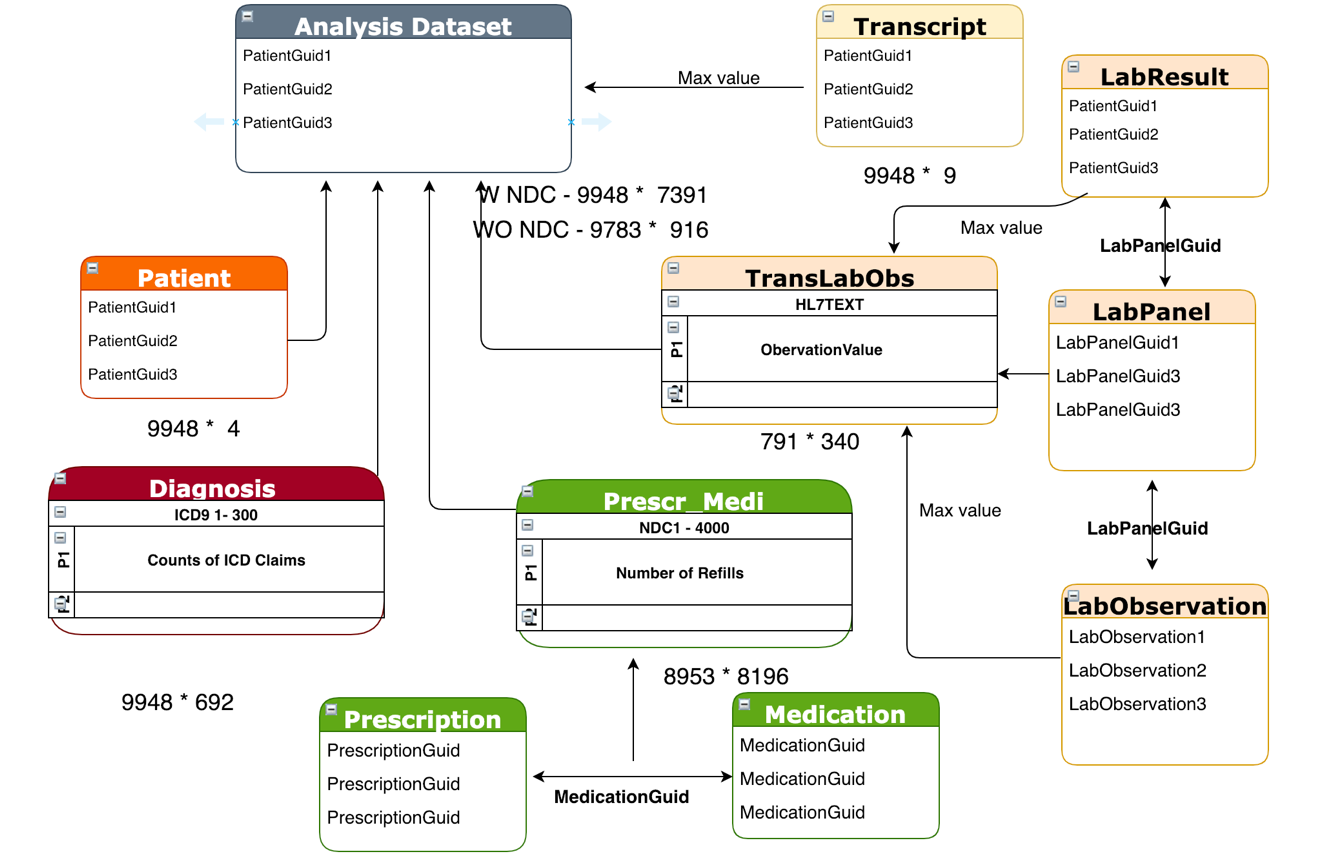

In [44]:
Trans_LabRes= pd.merge(LabResult,LabPanel,on=['LabResultGuid'],how='left')
Trans_LabRes_Obs = pd.merge(Trans_LabRes,LabObservation,on=['LabPanelGuid'],how='left')
Trans_LabRes_Obs = Trans_LabRes_Obs[['PatientGuid','HL7Text','ObservationValue']]
Trans_LabRes_Obs_2 = Trans_LabRes_Obs.groupby(['PatientGuid','HL7Text'],as_index=True).agg({'ObservationValue':'max'})
Trans_LabRes_Obs_2 = Trans_LabRes_Obs_2.unstack(level=-1,fill_value=0.0)
Trans_LabRes_Obs_2['PatientGuid'] = Trans_LabRes_Obs_2.index
Trans_LabRes_Obs_2.reset_index(inplace=True, drop=True)

In [45]:
Trans_LabRes_Obs.head(6)

,PatientGuid,HL7Text,ObservationValue
0,ECD01885-2FB6-41D2-9220-286F67F57282,Hematocrit,43.0
1,ECD01885-2FB6-41D2-9220-286F67F57282,Hemoglobin,14.6
2,ECD01885-2FB6-41D2-9220-286F67F57282,Monocytes,1.0
3,ECD01885-2FB6-41D2-9220-286F67F57282,Neutrophils,6.8
4,ECD01885-2FB6-41D2-9220-286F67F57282,Platelets,219.0
5,ECD01885-2FB6-41D2-9220-286F67F57282,Globulin,2.5


In [47]:
Transcript_2 = Transcript[['PatientGuid','Height','Weight','BMI','SystolicBP','DiastolicBP','RespiratoryRate','HeartRate','Temperature']]
Transcript_2 = Transcript_2.groupby(['PatientGuid'],as_index=True)['Height','Weight','BMI','SystolicBP','DiastolicBP','RespiratoryRate','HeartRate','Temperature'].apply(lambda x : x.astype(float).max())
Transcript_2['PatientGuid'] = Transcript_2.index
Transcript_2.reset_index(inplace=True, drop=True)

In [48]:
Transcript_3= pd.merge(Transcript_2,Trans_LabRes_Obs_2,on=['PatientGuid'],how='left')

/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


## Calculate 
### 1) Patient Age 
### 2) Number of Refills per National Drug Code (NDC)


In [49]:

Patient['Age'] = (pd.to_datetime('today').year-Patient['YearOfBirth'])

Prescription_ch = Prescription[['PatientGuid','MedicationGuid','PrescriptionYear','NumberOfRefills']]

Pat_Medi_Prescr = pd.merge(Medication,Prescription_ch,on=['PatientGuid','MedicationGuid'],how='inner')


Pat_Medi_Prescr_2 = Pat_Medi_Prescr[['PatientGuid','PrescriptionYear','NumberOfRefills','NdcCode']]

Pat_Medi_Prescr_2 = Pat_Medi_Prescr[['PatientGuid','PrescriptionYear','NumberOfRefills','NdcCode']]
Pat_Medi_Prescr_2['NdcCode']= Pat_Medi_Prescr_2.NdcCode.map(lambda x: '{:.0f}'.format(x))

Pat_Medi_Prescr_2['NumberOfRefills'] = Pat_Medi_Prescr_2['NumberOfRefills'].apply(pd.to_numeric, args=('coerce',))

Pat_Medi_Prescr_2 = Pat_Medi_Prescr_2[['PatientGuid','NdcCode','NumberOfRefills']].groupby(['PatientGuid','NdcCode'],as_index=True).agg({'NumberOfRefills':'sum'})



Pat_Medi_Prescr_2 = Pat_Medi_Prescr_2.unstack(level=-1,fill_value=0.0)

Pat_Medi_Prescr_2['PatientGuid'] = Pat_Medi_Prescr_2.index
Pat_Medi_Prescr_2.reset_index(inplace=True, drop=True)



/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


## Keep Minimum of Smoking Status Indicator value of the Patient 

In [50]:
smoke_Obs = pd.merge(Patient[['PatientGuid']],(pd.merge(PatientSmokingStatus,SmokingStatus,on='SmokingStatusGuid',how='inner')),on='PatientGuid',how='inner')
smoke_Obs= smoke_Obs.drop(['SmokingStatusGuid'],axis=1)
smoke_Obs_3 = smoke_Obs[['PatientGuid','NISTcode']].groupby(['PatientGuid'],as_index=False).agg({'NISTcode':'min'})
smoke_Obs_3.head()

,PatientGuid,NISTcode
0,000B4862-7CE7-4EC5-8043-A97FCD74BD78,3
1,0029BBC8-7C22-4444-9F44-87BEF05FE033,3
2,003CEE1F-5BF5-4171-9284-F5464EC12D41,4
3,005F61C9-E537-4AD2-B39C-37F25891F33A,4
4,0063B34F-C2C4-423A-A144-E51F7149253A,0


## Create patient level diagnosis dataset with 3 digit ICD9 diag as column and then count existing diagnosis for that patient 

In [51]:
Diagnosis_2 =Diagnosis
Diagnosis_2 = Diagnosis_2[['PatientGuid','ICD9Code']]
Diagnosis_2['ICD9Code_1'] = Diagnosis_2.ICD9Code.str[:3]
Diagnosis_2['DropPat'] = np.where(Diagnosis_2.ICD9Code.str[:3]=='250', 1, 0)
Diagnosis_3 = Diagnosis_2.groupby(['PatientGuid','ICD9Code_1'],as_index=True).agg({'ICD9Code_1':'count'}).rename(columns={'ICD9Code_1':'ICD9'})

Diagnosis_3 = Diagnosis_3.unstack(level=-1,fill_value=0.0)
#Diagnosis_3.head()

Diagnosis_3["PatientGuid"] = Diagnosis_3.index
Diagnosis_3.reset_index(inplace=True, drop=True)

Diagnosis_4 = Diagnosis[['PatientGuid','Acute']]
Diagnosis_4 = Diagnosis_4[['PatientGuid','Acute']].groupby(['PatientGuid'],as_index=True).agg({'Acute':'sum'})
Diagnosis_5 = pd.merge(Diagnosis_3,Diagnosis_4,on='PatientGuid',how='inner')
Diagnosis_5= Diagnosis_5.drop(Diagnosis_5.columns[691], axis=1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on

In [67]:
Diagnosis_5.head()

,PatientGuid,"(ICD9, 002)","(ICD9, 003)","(ICD9, 005)","(ICD9, 007)","(ICD9, 008)","(ICD9, 009)","(ICD9, 010)","(ICD9, 011)","(ICD9, 012)","(ICD9, 027)","(ICD9, 031)","(ICD9, 033)","(ICD9, 034)","(ICD9, 035)","(ICD9, 038)","(ICD9, 039)","(ICD9, 040)","(ICD9, 041)","(ICD9, 042)","(ICD9, 043)","(ICD9, 047)","(ICD9, 051)","(ICD9, 052)","(ICD9, 053)","(ICD9, 054)","(ICD9, 057)","(ICD9, 058)","(ICD9, 070)","(ICD9, 074)","(ICD9, 075)","(ICD9, 077)","(ICD9, 078)","(ICD9, 079)","(ICD9, 084)","(ICD9, 088)","(ICD9, 091)","(ICD9, 092)","(ICD9, 098)","(ICD9, 099)","(ICD9, 110)","(ICD9, 111)","(ICD9, 112)","(ICD9, 114)","(ICD9, 116)","(ICD9, 117)","(ICD9, 127)","(ICD9, 129)","(ICD9, 131)","(ICD9, 132)","(ICD9, 133)","(ICD9, 134)","(ICD9, 135)","(ICD9, 136)","(ICD9, 138)","(ICD9, 146)","(ICD9, 153)","(ICD9, 154)","(ICD9, 155)","(ICD9, 161)","(ICD9, 162)","(ICD9, 172)","(ICD9, 173)","(ICD9, 174)","(ICD9, 176)","(ICD9, 179)","(ICD9, 180)","(ICD9, 182)","(ICD9, 183)","(ICD9, 184)","(ICD9, 185)","(ICD9, 188)","(ICD9, 189)","(ICD9, 191)","(ICD9, 193)","(ICD9, 196)","(ICD9, 197)","(ICD9, 198)","(ICD9, 199)","(ICD9, 202)","(ICD9, 203)","(ICD9, 204)","(ICD9, 208)","(ICD9, 210)","(ICD9, 211)","(ICD9, 212)","(ICD9, 214)","(ICD9, 215)","(ICD9, 216)","(ICD9, 217)","(ICD9, 218)","(ICD9, 222)","(ICD9, 223)","(ICD9, 224)","(ICD9, 225)","(ICD9, 226)","(ICD9, 227)","(ICD9, 228)","(ICD9, 230)","(ICD9, 231)","(ICD9, 232)","(ICD9, 233)","(ICD9, 235)","(ICD9, 236)","(ICD9, 237)","(ICD9, 238)","(ICD9, 239)","(ICD9, 240)","(ICD9, 241)","(ICD9, 242)","(ICD9, 243)","(ICD9, 244)","(ICD9, 245)","(ICD9, 246)","(ICD9, 249)","(ICD9, 250)","(ICD9, 251)","(ICD9, 252)","(ICD9, 253)","(ICD9, 255)","(ICD9, 256)","(ICD9, 257)","(ICD9, 259)","(ICD9, 262)","(ICD9, 263)","(ICD9, 265)","(ICD9, 266)","(ICD9, 268)","(ICD9, 269)","(ICD9, 270)","(ICD9, 271)","(ICD9, 272)","(ICD9, 273)","(ICD9, 274)","(ICD9, 275)","(ICD9, 276)","(ICD9, 277)","(ICD9, 278)","(ICD9, 279)","(ICD9, 280)","(ICD9, 281)","(ICD9, 282)","(ICD9, 283)","(ICD9, 284)","(ICD9, 285)","(ICD9, 286)","(ICD9, 287)","(ICD9, 288)","(ICD9, 289)","(ICD9, 290)","(ICD9, 291)","(ICD9, 292)","(ICD9, 293)","(ICD9, 294)","(ICD9, 295)","(ICD9, 296)","(ICD9, 297)","(ICD9, 298)","(ICD9, 299)","(ICD9, 300)","(ICD9, 301)","(ICD9, 302)","(ICD9, 303)","(ICD9, 304)","(ICD9, 305)","(ICD9, 306)","(ICD9, 307)","(ICD9, 308)","(ICD9, 309)","(ICD9, 310)","(ICD9, 311)","(ICD9, 312)","(ICD9, 313)","(ICD9, 314)","(ICD9, 315)","(ICD9, 316)","(ICD9, 317)","(ICD9, 318)","(ICD9, 319)","(ICD9, 324)","(ICD9, 327)","(ICD9, 331)","(ICD9, 332)","(ICD9, 333)","(ICD9, 334)","(ICD9, 335)","(ICD9, 336)","(ICD9, 337)","(ICD9, 338)","(ICD9, 339)","(ICD9, 340)","(ICD9, 341)","(ICD9, 342)","(ICD9, 343)","(ICD9, 344)","(ICD9, 345)","(ICD9, 346)","(ICD9, 347)","(ICD9, 348)","(ICD9, 349)","(ICD9, 350)","(ICD9, 351)","(ICD9, 353)","(ICD9, 354)","(ICD9, 355)","(ICD9, 356)","(ICD9, 357)","(ICD9, 358)","(ICD9, 359)","(ICD9, 360)","(ICD9, 361)","(ICD9, 362)","(ICD9, 364)","(ICD9, 365)","(ICD9, 366)","(ICD9, 367)","(ICD9, 368)","(ICD9, 369)","(ICD9, 370)","(ICD9, 371)","(ICD9, 372)","(ICD9, 373)","(ICD9, 374)","(ICD9, 375)","(ICD9, 376)","(ICD9, 377)","(ICD9, 378)","(ICD9, 379)","(ICD9, 380)","(ICD9, 381)","(ICD9, 382)","(ICD9, 383)","(ICD9, 384)","(ICD9, 385)","(ICD9, 386)","(ICD9, 388)","(ICD9, 389)","(ICD9, 390)","(ICD9, 394)","(ICD9, 395)","(ICD9, 396)","(ICD9, 397)","(ICD9, 398)","(ICD9, 401)","(ICD9, 402)","(ICD9, 403)","(ICD9, 404)","(ICD9, 405)","(ICD9, 410)","(ICD9, 411)",...,"(ICD9, 684)","(ICD9, 685)","(ICD9, 686)","(ICD9, 690)","(ICD9, 691)","(ICD9, 692)","(ICD9, 693)","(ICD9, 694)","(ICD9, 695)","(ICD9, 696)","(ICD9, 697)","(ICD9, 698)","(ICD9, 700)","(ICD9, 701)","(ICD9, 702)","(ICD9, 703)","(ICD9, 704)","(ICD9, 705)","(ICD9, 706)","(ICD9, 707)","(ICD9, 708)","(ICD9, 709)","(ICD9, 710)","(ICD9, 711)","(ICD9, 712)","(ICD9, 713)","(ICD9, 714)","(ICD9, 715)","(ICD9, 716)","(ICD9, 717)","(ICD9, 718)","(ICD9, 719)","(ICD9, 720)","(ICD9, 721)","(ICD9, 722)","(ICD9,

## As Per Assignment problem Patient with Diagnosis code as ‘250’ should not be considered for analysis 

In [68]:
Diagnosis_drop = Diagnosis_2.loc[Diagnosis_2['DropPat'] == 1, ['PatientGuid','DropPat']]
Diagnosis_drop.drop_duplicates(inplace=True)
print(Diagnosis_drop.head())
Diagnosis_drop.count()

                               PatientGuid  DropPat
161   D76FC581-580A-4988-B13F-D4E9BD6763EA        1
392   F6E5C45F-D7D6-491E-8CC7-06E3FC6DA86C        1
435   74F0B121-DFF6-4238-93AE-F7D2333A0EF1        1
1278  D33A261B-8AC7-4999-B3B9-0DFBDC1A9662        1
1433  B4002DE2-E2C2-4C9A-A165-7701BEB647D4        1


PatientGuid    165
DropPat        165
dtype: int64

In [242]:
Int_Pat = pd.merge(Patient[['PatientGuid','DMIndicator','Gender','Age']],\
                   Diagnosis_drop[['PatientGuid','DropPat']],on='PatientGuid',how='left')

Final_Pat = pd.merge(Int_Pat,Diagnosis_5,on='PatientGuid',how='left')
Final_Pat_1 = pd.merge(Final_Pat,Transcript_3,on='PatientGuid',how='left')
#Final_Pat_2 = pd.merge(Final_Pat_1,Pat_Medi_Prescr_2,on='PatientGuid',how='left')

Final_Pat_3 = Final_Pat_1

Final_Pat_3['DMIndicator'] = Final_Pat_3['DMIndicator'].astype('category')

Final_Pat_4 = Final_Pat_3.loc[:, (Final_Pat_3 != 0).any(axis=0)]

Final_Pat_4 = Final_Pat_4[Final_Pat_4.DropPat != 1]

Final_Pat_4 = pd.concat([Final_Pat_4,pd.get_dummies(Final_Pat_4[['Gender']],dummy_na=True)],axis=1).\
                drop(['Gender','DropPat'],axis=1)
Final_Pat_4=Final_Pat_4.fillna(value=0)
Final_Pat_4 = Final_Pat_4.loc[:, (Final_Pat_4 != 0).any(axis=0)]

In [243]:

Patient['Age'].mean()

62.60394049055086

In [244]:
Final_Pat_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9783 entries, 0 to 9947
Columns: 916 entries, PatientGuid to Gender_M
dtypes: category(1), float64(910), int64(2), object(1), uint8(2)
memory usage: 68.2+ MB


## Plot Histogram of Age 

<Figure size 432x288 with 0 Axes>

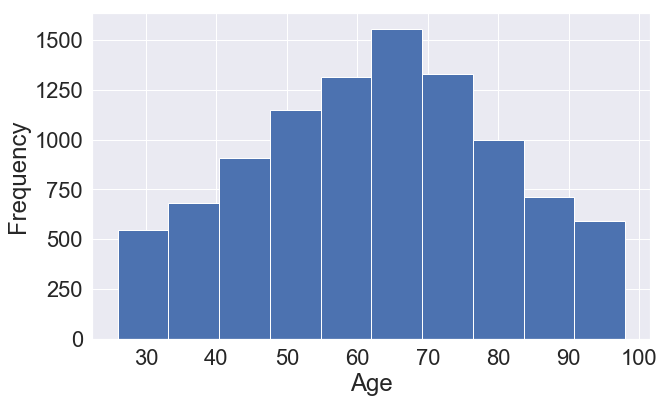

In [245]:
plt.figure();
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel("Age")
ax.set_ylabel("Frequency")
Final_Pat_4['Age'].plot.hist()

## Plot Target Variable 

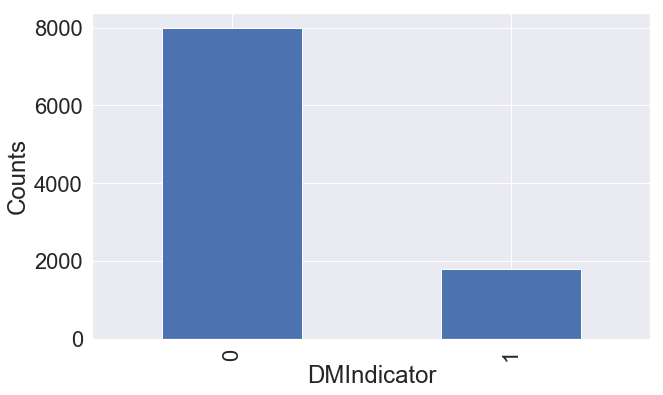

In [246]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel("DMIndicator")
ax.set_ylabel("Counts")
Final_Pat_4['DMIndicator'].value_counts().plot(kind='bar')

## See proportion of Target Variable in Sample dataset

In [31]:
Final_Pat_4['DMIndicator'].value_counts()/len(Final_Pat_4['DMIndicator'])

0    0.815496
1    0.184504
Name: DMIndicator, dtype: float64

## Plot DMIndicator by Gender 

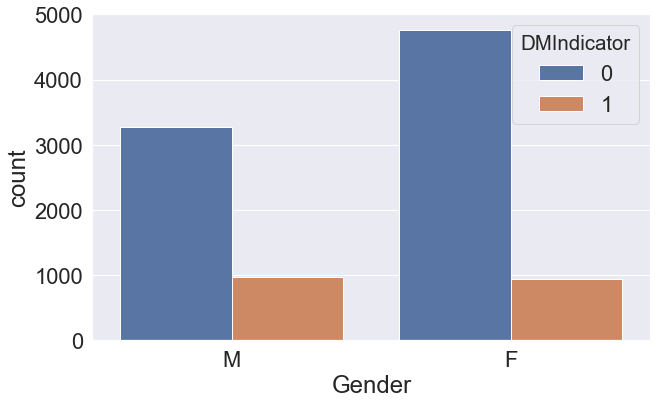

In [58]:
#ax = Final_Pat[['DMIndicator','Gender']].plot.bar(rot=0)
sns.set(font_scale=2)

fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(x="Gender", hue="DMIndicator", data=Final_Pat)

## Understand Effect of Age on Target Variable 

[(0, 100)]

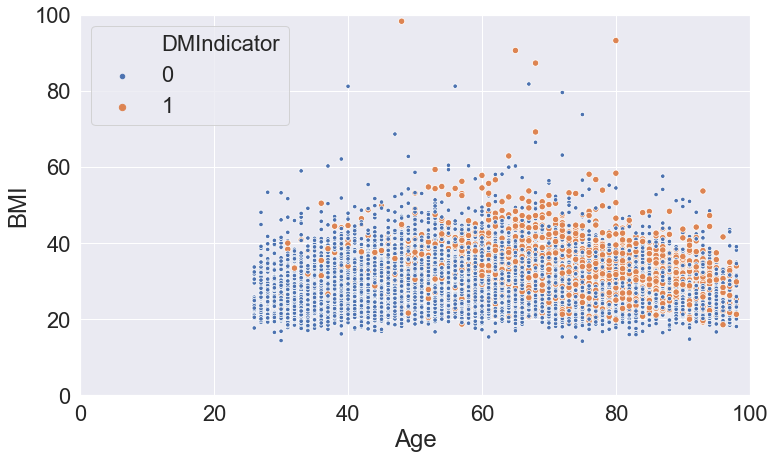

In [61]:
fig, ax = plt.subplots(figsize=(12,7))
sns.set(font_scale=2)

ax = sns.scatterplot(y="BMI",x= 'Age',hue="DMIndicator" , size="DMIndicator",sizes=(40, 20),data=Final_Pat_3)
ax.set(xlim=(0, 100))
ax.set(ylim=(0, 100))

## Understand Effect of SystolicBP & BMI on Target Variable

[(0, 270)]

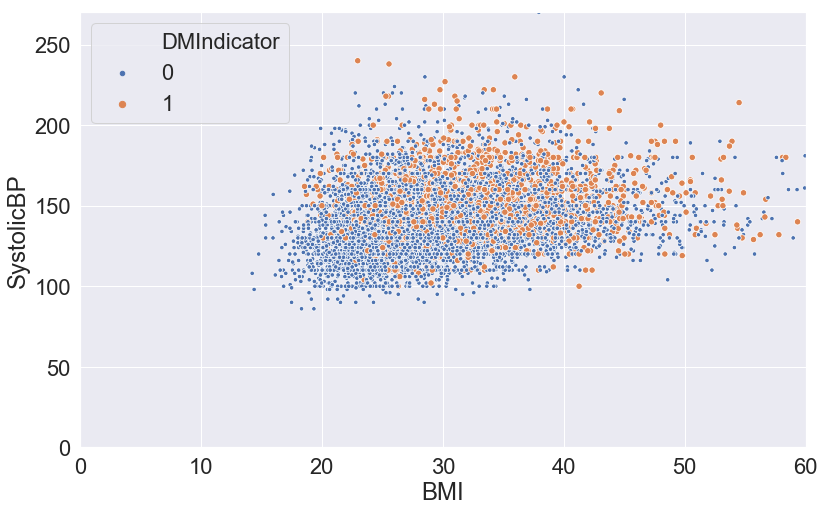

In [62]:
#sns.plt.xlim(0, 50)
fig, ax = plt.subplots(figsize=(13,8))
sns.set(font_scale=2)


ax = sns.scatterplot(x="BMI",y= 'SystolicBP',hue="DMIndicator" , size="DMIndicator",sizes=(40, 20),data=Final_Pat_3)
ax.set(xlim=(0, 60))
ax.set(ylim=(0, 270))

## Understand Effect of Height & Temperature on Target Variable

[(60, 120)]

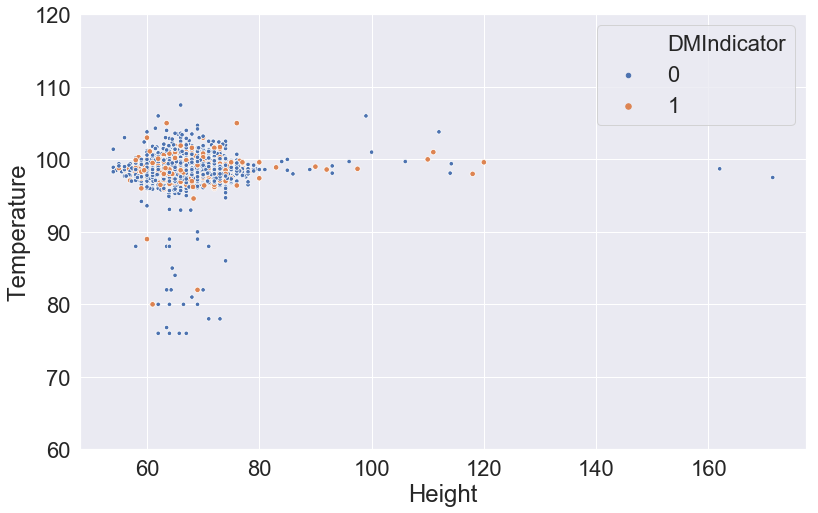

In [63]:
#sns.plt.xlim(0, 50)
fig, ax = plt.subplots(figsize=(13,8))
sns.set(font_scale=2)


ax = sns.scatterplot(x="Height",y= 'Temperature',hue="DMIndicator" , size="DMIndicator",sizes=(30, 20),data=Final_Pat_3)
#ax.set(xlim=(0, 30))
ax.set(ylim=(60, 120))

## Flatten Column Names 

In [247]:
string1 = list(Final_Pat_4.columns)
string1 = [' '.join(col).strip() for col in Final_Pat_4.columns.values]
string1 = map(lambda x : x.replace(' ', ''),string1)

Final_Pat_4.columns = string1

In [248]:
Final_Pat_4 = Final_Pat_4.loc[:,~Final_Pat_4.columns.duplicated()]

## Split Final dataset into Train and Test dataset with 70-30 Ratio  

In [250]:
y_var = Final_Pat_4.DMIndicator.astype('float64')
#y_var = pd.Categorical.from_codes(Final_Pat_4.DMIndicator,categories=[0,1])
x_var = Final_Pat_4.drop([ 'DMIndicator', 'PatientGuid'], axis = 1).astype('float64')
X_train, X_test , y_train, y_test = train_test_split(x_var, y_var, test_size=0.3, random_state=1)

In [251]:
list(X_test.columns)

['Age',
 'ICD9003',
 'ICD9005',
 'ICD9007',
 'ICD9008',
 'ICD9009',
 'ICD9011',
 'ICD9012',
 'ICD9027',
 'ICD9031',
 'ICD9033',
 'ICD9034',
 'ICD9035',
 'ICD9038',
 'ICD9039',
 'ICD9040',
 'ICD9041',
 'ICD9042',
 'ICD9043',
 'ICD9047',
 'ICD9051',
 'ICD9052',
 'ICD9053',
 'ICD9054',
 'ICD9057',
 'ICD9058',
 'ICD9070',
 'ICD9074',
 'ICD9075',
 'ICD9077',
 'ICD9078',
 'ICD9079',
 'ICD9084',
 'ICD9088',
 'ICD9091',
 'ICD9092',
 'ICD9098',
 'ICD9099',
 'ICD9110',
 'ICD9111',
 'ICD9112',
 'ICD9114',
 'ICD9116',
 'ICD9117',
 'ICD9127',
 'ICD9129',
 'ICD9131',
 'ICD9132',
 'ICD9133',
 'ICD9134',
 'ICD9135',
 'ICD9136',
 'ICD9138',
 'ICD9146',
 'ICD9153',
 'ICD9154',
 'ICD9155',
 'ICD9161',
 'ICD9162',
 'ICD9172',
 'ICD9173',
 'ICD9174',
 'ICD9176',
 'ICD9179',
 'ICD9180',
 'ICD9182',
 'ICD9183',
 'ICD9184',
 'ICD9185',
 'ICD9188',
 'ICD9189',
 'ICD9191',
 'ICD9193',
 'ICD9196',
 'ICD9197',
 'ICD9198',
 'ICD9199',
 'ICD9202',
 'ICD9203',
 'ICD9204',
 'ICD9208',
 'ICD9210',
 'ICD9211',
 'ICD921

In [252]:
len(X_test.columns)

911

## Run RandomForest Classifier

In [218]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=500,random_state= 1) #,random_state=0, n_jobs=-1, class_weight="balanced")
clf.fit(X_train,y_train) # , sample_weight = np.array([8 if i == 1 else 1 for i in y_train]))

y_pred=clf.predict(X_test)

from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("precision_score:",metrics.precision_score(y_test, y_pred))
print("recall_score:",metrics.recall_score(y_test, y_pred))
predicted_proba = clf.predict_proba(X_test)
print("brier_score_loss:",metrics.brier_score_loss(y_test, predicted_proba[:,1]))
print("confusion_matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

Accuracy: 0.8156729131175469
precision_score: 0.65625
recall_score: 0.11033274956217162
brier_score_loss: 0.12424124701873934
confusion_matrix:
[[2331   33]
 [ 508   63]]


[[2331   33]
 [ 508   63]]


<Figure size 432x288 with 0 Axes>

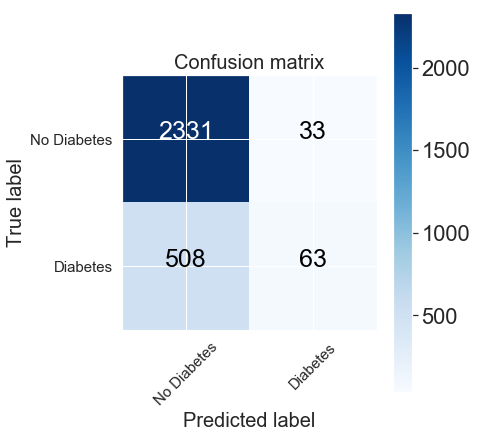

In [219]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
 #   if normalize:
 #       cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 #       print("Normalized confusion matrix")
 #   else:
 #       print('Confusion matrix, without normalization')

    print(cm)
    fig, ax = plt.subplots(figsize=(7, 7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)
    plt.title('Confusion matrix',fontsize=20)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),fontsize=25,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)
    plt.tight_layout()

class_names = ['No Diabetes','Diabetes']


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')


## Understand Feature Importance from RandomForest

In [220]:
feature_imp = pd.Series(clf.feature_importances_,index=list(X_train)).sort_values(ascending=False)
list(feature_imp.index[:21])

['Age',
 'BMI',
 'Weight',
 'SystolicBP',
 'ICD9401',
 'ICD9272',
 'DiastolicBP',
 'Height',
 'Temperature',
 'RespiratoryRate',
 'Acute',
 'ICD9585',
 'ICD9414',
 'ICD9715',
 'ICD9724',
 'ICD9780',
 'ICD9786',
 'ICD9530',
 'ICD9278',
 'ICD9300',
 'ICD9477']

No handles with labels found to put in legend.


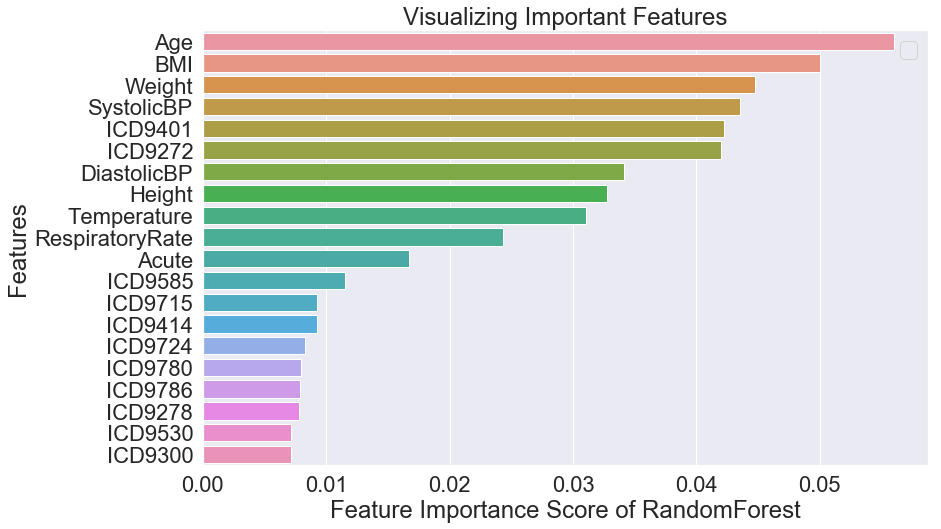

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_imp1  = feature_imp.head(20)

feature_imp1.index = list(feature_imp.index[:20])

# Creating a bar plot
fig, ax = plt.subplots(figsize=(13,8))
sns.set(font_scale=2)
sns.barplot(x=feature_imp1, y=feature_imp1.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score of RandomForest')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

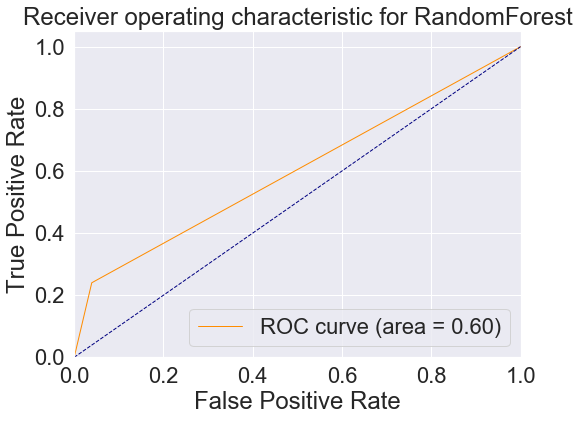

In [183]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()

fig, ax = plt.subplots(figsize=(8,6))
sns.set(font_scale=2)
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for RandomForest')
plt.legend(loc="lower right")
plt.show()

## Run Support Vector Machine Algorithm, with RBF Kernel

In [159]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

clf = svm.SVC(gamma='scale',class_weight="balanced",C=1.0,  probability=True, random_state=0,kernel='rbf',shrinking=True,decision_function_shape='ovr')
clf.fit(X_train,y_train)
y_pred2=clf.predict(X_test)

Accuracy: 0.6545144804088586
precision_score: 0.3328301886792453
recall_score: 0.7723292469352014
brier_score_loss: 0.13465960603153482
confusion_matrix: [[1480  884]
 [ 130  441]]
[[1480  884]
 [ 130  441]]


<Figure size 432x288 with 0 Axes>

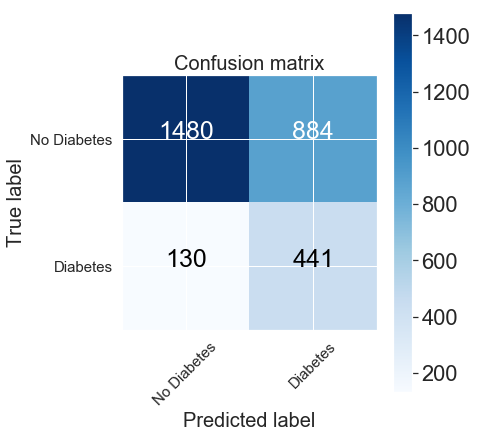

In [160]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred2))
print("precision_score:",metrics.precision_score(y_test , y_pred2))
print("recall_score:",metrics.recall_score(y_test, y_pred2))
predicted_proba = clf.predict_proba(X_test)
print("brier_score_loss:",metrics.brier_score_loss(y_test, predicted_proba[:,1]))

print("confusion_matrix:",metrics.confusion_matrix(y_test, y_pred2))

# Compute confusion matrix
cnf_matrix2 = confusion_matrix(y_test, y_pred2)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix2, classes=class_names,
                      title='Confusion matrix, without normalization')

<Figure size 432x288 with 0 Axes>

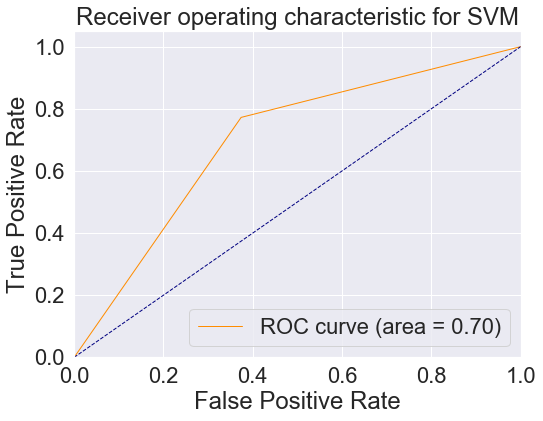

In [180]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test,y_pred2)
roc_auc = auc(fpr, tpr)

plt.figure()

fig, ax = plt.subplots(figsize=(8,6))
sns.set(font_scale=2)
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for SVM')
plt.legend(loc="lower right")
plt.show()

## Run XGBoost Classifier 

In [221]:

#from numpy import loadtxt
from xgboost import XGBClassifier,plot_importance



model = XGBClassifier(n_estimators=200,random_state=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("precision_score:",metrics.precision_score(y_test , y_pred))
print("recall_score:",metrics.recall_score(y_test, y_pred))
predicted_proba = model.predict_proba(X_test)
print("brier_score_loss:",metrics.brier_score_loss(y_test, predicted_proba[:,1]))


Accuracy: 0.8204429301533219
precision_score: 0.5956521739130435
recall_score: 0.23992994746059546
brier_score_loss: 0.12300557960564858


['BMI', 0.08428805]
['Age', 0.07692308]
['Weight', 0.062193125]
['SystolicBP', 0.04418985]
['Temperature', 0.04337152]
['ICD9272', 0.0400982]
['DiastolicBP', 0.036006548]
['Height', 0.033551555]
['Acute', 0.02618658]
['RespiratoryRate', 0.024549918]
['ICD9401', 0.020458264]
['ObservationValuePotassium', 0.015548281]
['ICD9585', 0.013911621]
['ICD9724', 0.012274959]
['ObservationValueAlbumin/Globulin', 0.012274959]
['ICD9300', 0.011456628]
['ICD9053', 0.011456628]
['ICD9V70', 0.011456628]
['ICD9V77', 0.011456628]
['ICD9285', 0.011456628]
['ICD9443', 0.009819968]
['ObservationValueTriglyceride', 0.009001637]
['ICD9681', 0.0073649753]
['ICD9428', 0.0073649753]
['ICD9473', 0.0073649753]
['ICD9414', 0.0073649753]
['ICD9627', 0.0073649753]
['ObservationValueHematocrit', 0.0073649753]
['ICD9244', 0.0073649753]
['ICD9780', 0.0073649753]


<Figure size 1200x960 with 0 Axes>

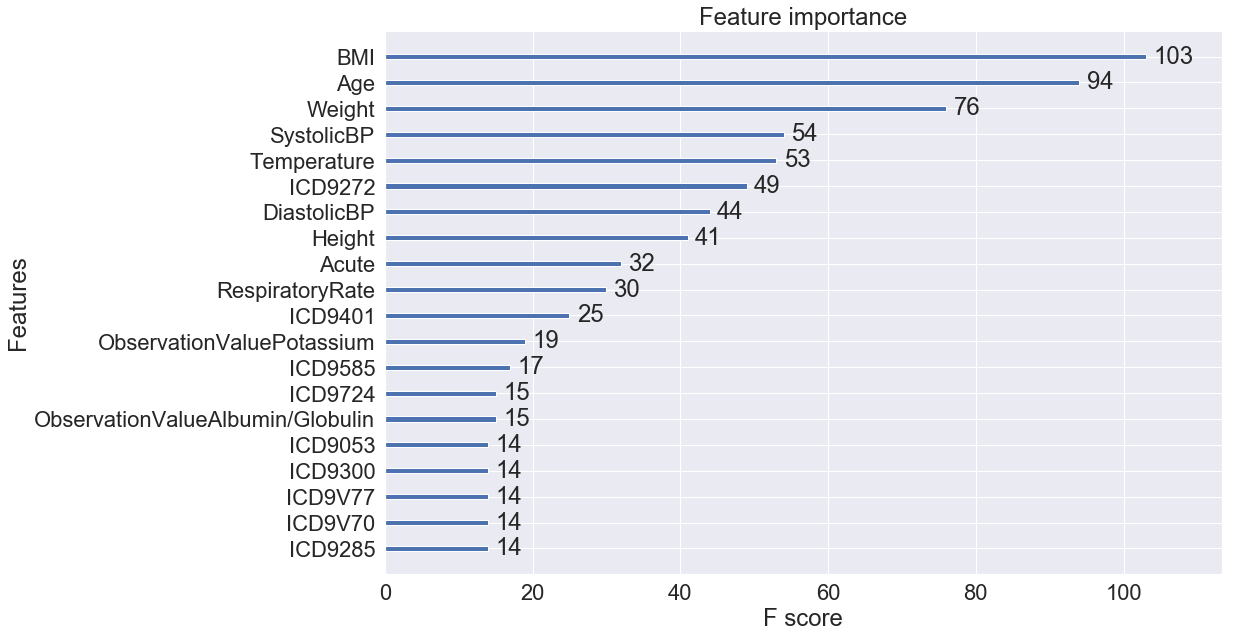

In [222]:
from xgboost import plot_importance

sorted_idx = np.argsort(model.feature_importances_)[::-1]    
for index in sorted_idx[:30]:
    print([X_train.columns[index], model.feature_importances_[index]])

from matplotlib.pyplot import figure
plt.figure(num=None, figsize=(15, 12), dpi=80, facecolor='w', edgecolor='k')

#plot_importance(model, max_num_features = 20)
#plt.show()

ax = plot_importance(model, max_num_features = 20)
fig = ax.figure
fig.set_size_inches(15, 10)

<Figure size 432x288 with 0 Axes>

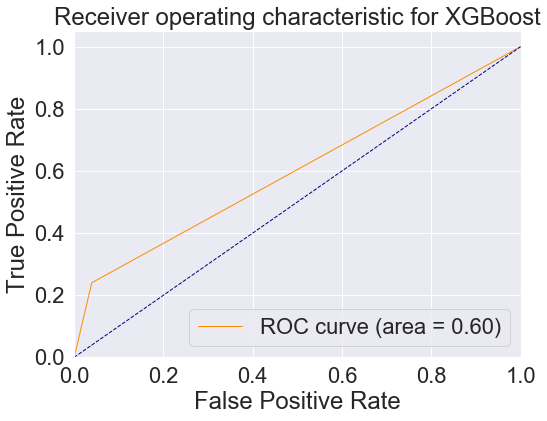

In [202]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test,y_pred3)
roc_auc = auc(fpr, tpr)

plt.figure()
fig, ax = plt.subplots(figsize=(8,6))
sns.set(font_scale=2)
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for XGBoost')
plt.legend(loc="lower right")
plt.show()

## Try SMOTE oversampling technique to bring minority samples to 50- 50 ratio with majority sample

In [262]:
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split


y_var2 = Final_Pat_4.DMIndicator
x_var2 = Final_Pat_4.drop([ 'DMIndicator', 'PatientGuid'], axis = 1).astype('float64')
X_train2, X_test2 , y_train2, y_test2 = train_test_split(x_var2, y_var2, test_size=0.3, random_state=1)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

sm = SMOTE(random_state=1)
X_train_res, y_train_res = sm.fit_sample(X_train2.as_matrix(), y_train2.as_matrix())

Number transactions X_train dataset:  (6848, 911)
Number transactions y_train dataset:  (6848,)
Number transactions X_test dataset:  (2935, 911)
Number transactions y_test dataset:  (2935,)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


In [263]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

print(' the shape of test_X: {}'.format(X_test2.shape))
print('the shape of test_y: {} \n'.format(y_test2.shape))

After OverSampling, the shape of train_X: (11228, 911)
After OverSampling, the shape of train_y: (11228,) 

After OverSampling, counts of label '1': 5614
After OverSampling, counts of label '0': 5614
 the shape of test_X: (2935, 911)
the shape of test_y: (2935,) 



In [264]:
model2 = XGBClassifier(n_estimators=200)
model2.fit(X_train_res, y_train_res)
y_pred3 = model2.predict(X_test2.as_matrix())

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [266]:
#predictions = [round(value) for value in y_pred]
print("Accuracy:",metrics.accuracy_score(y_test2, y_pred3))
print("precision_score:",metrics.precision_score(y_test2 , y_pred3))
print("recall_score:",metrics.recall_score(y_test2, y_pred3))
predicted_proba = model.predict_proba(X_test)
print("brier_score_loss without SMOTE:",metrics.brier_score_loss(y_test, predicted_proba[:,1]))


print("New brier_score_loss with SMOTE:",metrics.brier_score_loss(y_test2, y_pred3))



Accuracy: 0.81396933560477
precision_score: 0.5326370757180157
recall_score: 0.3572679509632224
brier_score_loss without SMOTE: 0.12300557960564858
New brier_score_loss with SMOTE: 0.18603066439522997


## SMOTE did not help to improve Brier score 

['ICD9272', 0.0400982]
['Age', 0.07692308]
['BMI', 0.08428805]
['ICD9401', 0.020458264]
['SystolicBP', 0.04418985]
['DiastolicBP', 0.036006548]
['Weight', 0.062193125]
['Temperature', 0.04337152]
['Acute', 0.02618658]
['ICD9585', 0.013911621]
['ICD9530', 0.005728314]
['ICD9724', 0.012274959]
['RespiratoryRate', 0.024549918]
['Height', 0.033551555]
['ICD9780', 0.0073649753]
['Gender_F', 0.004091653]
['ICD9414', 0.0073649753]
['ICD9715', 0.004091653]
['ICD9285', 0.011456628]
['ICD9428', 0.0073649753]
['ICD9V70', 0.011456628]
['ICD9300', 0.011456628]
['ICD9627', 0.0073649753]
['ICD9278', 0.0016366612]
['ICD9110', 0.004909984]
['ICD9607', 0.004091653]
['ICD9V04', 0.005728314]
['ICD9V72', 0.004091653]
['ICD9477', 0.0032733225]
['ICD9346', 0.006546645]
[[2271   93]
 [ 434  137]]


<Figure size 1200x960 with 0 Axes>

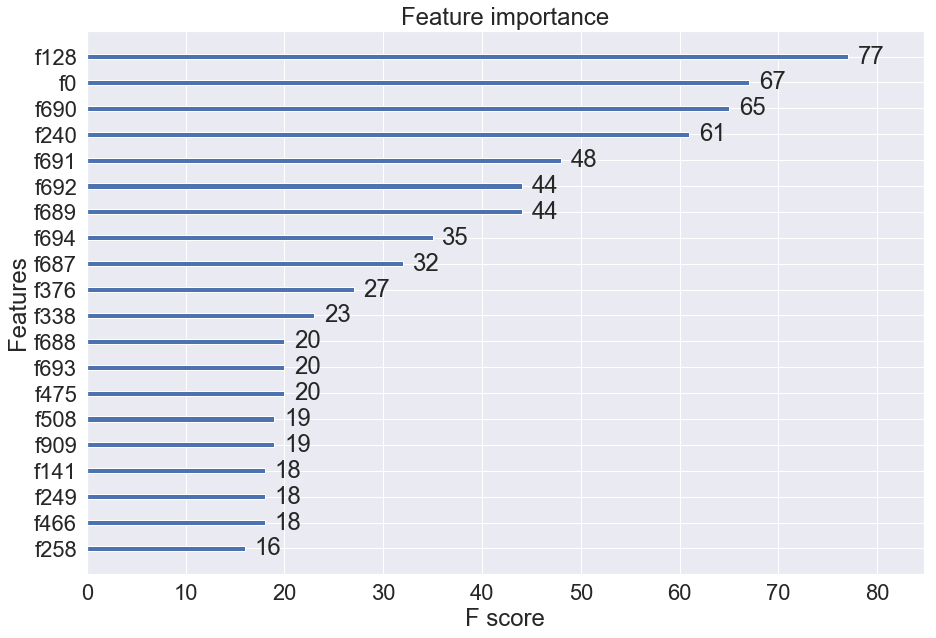

<Figure size 432x288 with 0 Axes>

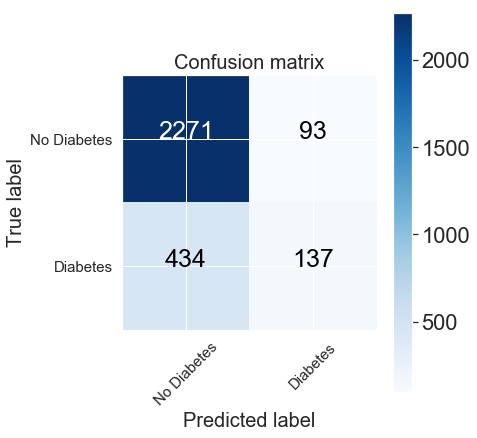

In [178]:
from xgboost import plot_importance

sorted_idx = np.argsort(model2.feature_importances_)[::-1]    
for index in sorted_idx[:30]:
    print([X_train.columns[index], model.feature_importances_[index]]) 

from matplotlib.pyplot import figure
plt.figure(num=None, figsize=(15, 12), dpi=80, facecolor='w', edgecolor='k')

#plot_importance(model, max_num_features = 20)
#plt.show()

ax = plot_importance(model2, max_num_features = 20)
fig = ax.figure
fig.set_size_inches(15, 10)

# Compute confusion matrix
cnf_matrix3 = confusion_matrix(y_test, y_pred3)
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix3, classes=class_names,
                      title='Confusion matrix, without normalization')

## Try GridSearch with RandomForest classifier to tune model parameters

In [277]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
    accuracy_score, precision_score, confusion_matrix,log_loss

clf = RandomForestClassifier(n_jobs=-1)
#clf = XGBClassifier(random_state=1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [33, 20,45],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20],
    'class_weight':[{0: w} for w in [1, 2, 4, 6, 10]]
}
#'class_weight':[{0: w} for w in [1, 2, 4, 6, 10]]
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'log_loss_score':make_scorer(log_loss)
}

def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)

    grid_search.fit(X_train_res, y_train_res)

    # make the predictions
    y_pred = grid_search.predict(X_test2.as_matrix())

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [278]:
grid_search_clf = grid_search_wrapper(refit_score='log_loss_score')

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Best params for log_loss_score
{'class_weight': {0: 2}, 'max_depth': 3, 'max_features': 3, 'min_samples_split': 3, 'n_estimators': 33}

Confusion matrix of Random Forest optimized for log_loss_score on the test data:
     pred_neg  pred_pos
neg      2364         0
pos       571         0
